## Ball-and-stick model
This notebook demonstrates the simulation of extracellular signals from a ball-and-stick neuron model equipped with an axon initial segment (AIS). The extracellular potentials are simulated for a 30x30 HD-MEA probe model. Remember to activate the environment where the requisite libraries were installed.

First, set the parameters in the file `ball_and_stick_params.py`. By default, the parameters are set to generate a single AIS distance (5 um) and a single rotation (0 degree) and a single soma position (origin) for this notebook.


In [1]:
# to use with jupyter notebook
# %matplotlib notebook

# to use with jupyter lab
%matplotlib widget 

%reload_ext autoreload
%autoreload 2

try:
    import MEAutility as mu
except:
    print('Install custom version of MEAutility')
import LFPy
import neuroplotlib as nplt
import numpy as np
import matplotlib.pylab as plt
from pathlib import Path
import pandas as pd
import time

# neuron
try:
    import neuron
except:
    print('NEURON is not installed.')

if not neuron.load_mechanisms('../mechanisms/'):
    print('Compile mod files in the mechanisms/ folder: from the mechanisms/ folder, run nrnivmodl')
    
from ball_and_stick_helper_funs import *
from ball_and_stick_params import *

### Check AIS position
Setting the distance from soma to proximal axon to 5 um for this demo. The variable is named paisl for proximal AIS length.

In [3]:
paisl   = all_paisl[0]
paisl_i = 0 #index
print('Setting AIS at', paisl, 'um from the soma')

Setting AIS at 5 um from the soma


### Instantiate the cell object

In [4]:
# Instantiate the cell
cell = instantiate_cell_with_custom_params(d_dend=d_dend, d_soma=d_soma, d_axon=d_axon, d_ais=d_ais,
                                           l_dend=l_dend, l_axonp=paisl, l_ais=l_ais, l_axond=l_axond, **cell_kwargs)

# Insert biophysics from the params_dict defined in ball_stick_params.py
insert_biophysics(cell, params_dict)

### Check soma position
For this demo, we set it to the origin. In the detailed simulation, 4 jittered positions were used.

In [5]:
soma_position = soma_pos_vec[0]
# Set cell position
cell.set_pos(soma_position[0], soma_position[1], soma_position[2]) 
print('Setting the soma position to ', soma_pos_vec[0])

Setting the soma position to  [0. 0. 0.]


### Check angle of rotation
This is set to a scalar, 0 degree for this demo.

In [6]:
theta = theta_vec[0]
theta_i = 0 #index
# Set cell rotation along the y axis
cell.set_rotation(0, np.radians(theta), 0)
print('Setting theta =', theta, 'degree')

Setting theta = 0 degree


### Quick look at the cell and the probe

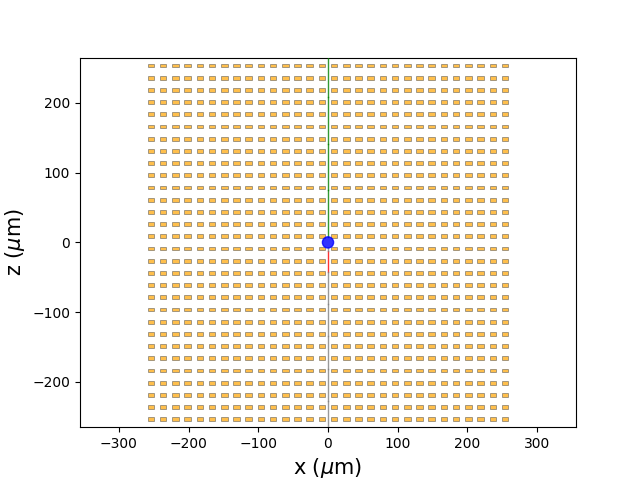

In [41]:
ax = mu.plot_probe(hdmea, type='planar')
nplt.plot_neuron(cell, ax=ax, plane='xz', color_ais='r', color_soma='b', color_dend='g');
ax.set_xlim([-265, 265]), ax.set_ylim([-265, 265]);

### Set stimulation parameters

In [8]:
stim_idx = cell.get_closest_idx(x=soma_position[0], y=soma_position[1], z=soma_position[2])
syn_params['idx'] = stim_idx
clamp_params['idx'] = stim_idx

if stim == 'syn':
    synapse = LFPy.Synapse(cell, **syn_params)
    synapse.set_spike_times(np.array(syn_input_times))
elif stim == 'iclamp':
    clamp = LFPy.StimIntElectrode(cell=cell, **clamp_params)

### Run the simulation 

In [9]:
t_start = time.time()
# Simulation
electrode = LFPy.RecExtElectrode(cell, probe=hdmea)
cell.simulate(probes=[electrode], rec_imem=True, rec_vmem=True)
eap = electrode.data * 1000  # eap is now in uV
SelectedTraces = eap[elmask]
t_end = time.time()
t_elapsed = round(t_end - t_start, 1)
print(f"Simulation done in {t_elapsed} s")

Simulation done in 0.3 s


### Plot extracellular electrical footprint

In [42]:
ax = mu.plot_mea_recording(eap, hdmea)
nplt.plot_neuron(cell, ax=ax, plane='xz', color_ais='r', color_soma='b', color_dend='g')
ax.set_xlim([-265, 265]), ax.set_ylim([-265, 265]);

### Plot selected traces around the neuron

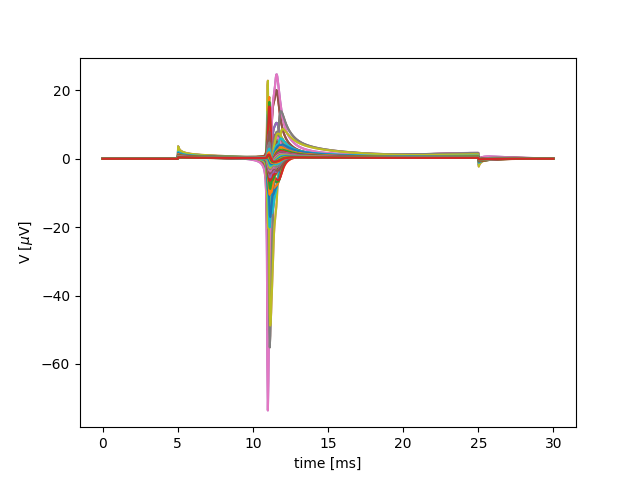

In [38]:
plt.figure()
plt.plot(cell.tvec, SelectedTraces.T);
plt.xlabel('time [ms]')
plt.ylabel('V [$\mu$V]');

### Record intracellularly from multiple compartments

In [23]:
idx_soma  = cell.get_closest_idx(0, 0, 0)
idx_dendp = cell.get_closest_idx(0, 0, 0.1 * l_dend)
idx_dendd = cell.get_closest_idx(0, 0, 0.8 * l_dend)
idx_axonp = cell.get_closest_idx(0, 0, -paisl // 2)
idx_ais   = cell.get_closest_idx(0, 0, -(paisl + l_ais // 2))
idx_axond = cell.get_closest_idx(0, 0, -(paisl + l_ais + l_axond // 2))

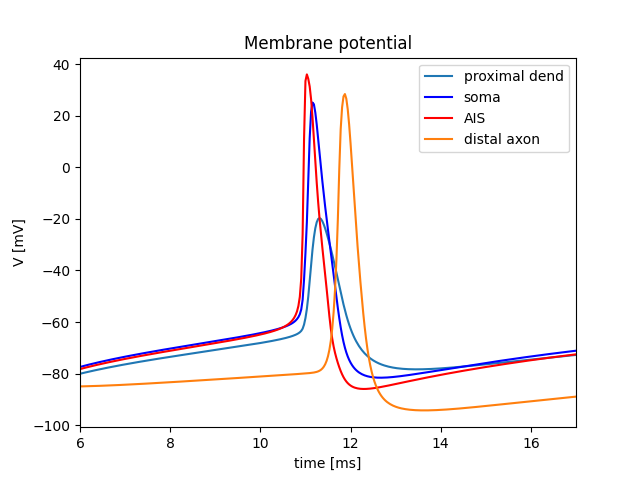

In [39]:
plt.figure()
plt.plot(cell.tvec, cell.vmem[idx_dendp], label='proximal dend')
plt.plot(cell.tvec, cell.vmem[idx_soma], label='soma', color='blue')
plt.plot(cell.tvec, cell.vmem[idx_ais], label='AIS', color='red')
plt.plot(cell.tvec, cell.vmem[idx_axond], label='distal axon')
plt.title("Membrane potential")
plt.legend()
plt.xlim([6, 17])
plt.xlabel('time [ms]')
plt.ylabel('V [mV]');